In [5]:
import json, pathlib, random, time
from collections import defaultdict
import numpy as np
import pandas as pd
import multiprocessing as mp

from environment import Env, validate_against_hint, load_word_lists, construct_word_df


In [6]:
df = construct_word_df(*load_word_lists())

In [7]:


def construct_state_tensor(guesses, history):
        #print(history)
        #so the state is going to be:
            #  The number of green locations we know
            #  The number of other letters we know to be in the word
            #  The sequence number of the guess (1st guess, 2nd guess etc.)

        #the number of locations which were green at some point in the history
        num_green_locs = np.count_nonzero(history.max(axis=0) == 2)

        green_chars = [guesses[x][y] for x,y in np.argwhere(history == 2) ]
        orange_chars = [guesses[x][y] for x,y in np.argwhere(history == 1) ]
        black_chars = [guesses[x][y] for x,y in np.argwhere(history == 0) ]
        num_other_letters = len(set(orange_chars) - set(green_chars))
        num_black_letters = len(set(black_chars))

        sequence_number = int(history.size / 5)
        #print(f'construct_state() with seqno {sequence_number}')

        sequence_number_onehot = np.zeros(Env.num_guesses)
        sequence_number_onehot[sequence_number] = 1.0
        arr = np.concatenate((np.array([num_green_locs, num_other_letters, num_black_letters])/5, sequence_number_onehot))
        return torch.tensor(arr, device=device, dtype=torch.float)
        

    

The aim here is to use a NN to represent the policy, rather than the value function.  We will shrink the action space (ie, so that we have a few actions, rather than 12000).  This will remove the model's ability to learn novel strategies, rather it will just be learning when to employ the different strategies (actions) that I give it.  Start w
ith these 3 word selection tactics:

1. choose words which match the current history
1. choose words which contain the greatest number of new letters
1. choose words which have the highest frequency score

then we will construct 6 actions by choosing every possible order of these strategies
1. 1,2,3
1. 1,3,2
1. 2,1,3
1. 2,3,1
1. 3,1,2
1. 3,2,1

for all these actions there may be multiple words, so sample a random one.  The policy then becomes a logistic regressor which selects one of these actions to execute.  The loss to train the regressor will be derived using the policy gradiet theorem.


In [8]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count, permutations

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.distributions import Categorical


# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

#plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def clear(self):
        self.memory.clear()
        
    def __len__(self):
        return len(self.memory)
    

In [10]:
class PolicyNetNN(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetNN, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 20)
        self.head = nn.Linear(20, num_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        x = F.relu(self.fc1(x))
        return F.softmax(self.head(x), dim=0)

In [11]:
class PolicyNetLinear(nn.Module):

    def __init__(self, num_inputs, num_actions):
        super(PolicyNetLinear, self).__init__()
        self.head = nn.Linear(num_inputs, num_actions)
        #print(f'PolicyNetLinear {num_inputs}, {num_actions}')

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = x.to(device)
        return F.softmax(self.head(x), dim=0)

In [46]:
#define the word-selection tactics
n_state_features = 9

class PolicyHelper:
    def __init__(self, env):
        self.env = env
        self.actions = [[env.find_target_words, env.find_words_matching_current_history, env.find_words_with_highest_new_letter_freq_score]]
        self.actions.append([env.find_words_with_highest_new_letter_freq_score, env.find_target_words, env.find_words_matching_current_history])
                
        self.num_actions = len(self.actions)
        #self.net = PolicyNetLinear(n_state_features, len(self.actions))
        
    def perform_action(self, action_idx):
        tactic_tuple = self.actions[action_idx]
        df = self.env.df
        for tactic in tactic_tuple: # apply all the tactics in the given order
            newdf = tactic(df)
            if not newdf.empty: #if that tactic produced no results, then quit
                df = newdf
        return df.sample()['word'][0] # then pick a random word from what is left
    
    

In [47]:





def plot_values(vals, axes=['duration', 'episode']):
    plt.figure(2)
    plt.clf()
    plt.title('Training...')
    plt.xlabel(axes[1])
    plt.ylabel(axes[0])
    plt.plot(np.array(vals))
    # Take 20 episode averages and plot them too
    window_width = 20
    if len(vals) >= window_width:
        cumsum_vec = np.cumsum(np.insert(vals, 0, 0)) 
        ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
        plt.plot(np.insert(ma_vec, 0, [None]*int(window_width/2)))

    plt.pause(0.001)  # pause a bit so that plots are updated
    #if is_ipython:
    #    display.clear_output(wait=True)
    #    display.display(plt.gcf())
    
def plot_all(episode_durations, episode_rewards, losses, epsilons, gammas):
    plot_values(episode_durations, axes=['duration', 'episode'])
    plot_values(episode_rewards, axes=['reward', 'episode'])
    if losses: plot_values(losses, axes=['loss', 'step'])
    if epsilons: plot_values(epsilons, axes=['epsilon', 'step'])
    if gammas: plot_values(gammas, axes=['gamma', 'step'])
    #plt.ioff()
    plt.show()

In [51]:
def optimize_model_batch(model, optimizer, memory, batch_size=128):
    transitions = memory.sample(batch_size)

    losses = [optimize_model_single(model, optimizer, tr.state, tr.action, tr.reward) for tr in transitions]
    
    return losses

def optimize_model_single(model, optimizer, state, action, reward):
        
    # calculate gradient
    probs = model(state)
    sampler = Categorical(probs)
    #print(f'sampler {sampler}')
    log_probs = -sampler.log_prob(action)   # "-" because it was built to work with gradient descent, but we are using gradient ascent

    pseudo_loss = log_probs * reward # loss that when differentiated with autograd gives the gradient of J(θ)
    #print(f'log_prob {log_probs}, reward {reward}, loss {pseudo_loss} ')
    # update policy weights
    optimizer.zero_grad()
    pseudo_loss.backward()
    optimizer.step()

    return pseudo_loss


class TrainConfig():
    def __init__(self, optimizer='adam', batch_size=64, train_interval=64, clear_memory=False, lr=0.01):
        self.optimizer = optimizer
        self.clear_memory = clear_memory
        self.lr = lr
        self.train_interval = train_interval
        self.batch_size = batch_size
        
class ValueConfig():
    def __init__(self, name='reward', gamma=[0.9, 0.05, 200]):
        self.name = name
        self.gamma = gamma
        
class ModelConfig():
    def __init__(self, name='naive', startword=None, target_list_only=None):
        self.name = name
        self.startword = startword
        self.target_list_only = target_list_only

In [49]:
#https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
def run_experiment(model=ModelConfig(name='naive', startword=None, target_list_only=False),
                   num_episodes=128,
                   eps=[0.9, 0.05, 200],
                   value_function=ValueConfig(name='reward',gamma=[0.0, 1.0, 200]),
                   training=TrainConfig(),
                   seed=0):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    GAMMA_START, GAMMA_END, GAMMA_DECAY = value_function.gamma
    env = Env(df)
    memory = ReplayMemory(10000)
    starting_state = construct_state_tensor(env.guesses, env.history)

    steps_done = 0
    last_training = 0
    losses = []
    episode_rewards = []
    episode_durations = []
    epsilons = []
    gammas = []
    
    policy_helper = PolicyHelper(env)
    
    if model.name == 'linear':
        policy_net = PolicyNetLinear(n_state_features, len(policy_helper.actions)).to(device)
    else:
        policy_net = PolicyNetNN(n_state_features, len(policy_helper.actions)).to(device)
        
    if training.optimizer == 'rmsprop':
        optimizer = optim.RMSprop(policy_net.parameters(), lr=training.lr)
    else:
        optimizer = optim.Adam(policy_net.parameters(), lr=training.lr)
        
    print(f'pn params {list(policy_net.parameters())}')
    for i_episode in range(num_episodes):
        # Initialize the environment and state
        env.reset()
        print(f'=========================episode {i_episode} {env.target}======================')

        episode_memory = []
        state = starting_state
        guesses = []
        for t in count():
            GAMMA = GAMMA_END + (GAMMA_START - GAMMA_END) * math.exp(-1. * steps_done / GAMMA_DECAY)
            gammas.append(GAMMA)
            steps_done += 1
            # Select and perform an action
            #print(state, actions)
            probs = policy_net(state)
            sampler = Categorical(probs)
            action_idx = sampler.sample()
            chosen_word = policy_helper.perform_action(action_idx)
            guesses.append(chosen_word)
            print(f'------guess {t} {action_idx} {guesses[-1]}-------')
            history, reward, done = env.step(chosen_word)
            #here next_state == env.history
            if not done:
                next_state = construct_state_tensor(guesses, history)
            
            #action_tensor = action_idx.clone().detach()
            action = action_idx #F.one_hot(action_idx, num_classes=policy_helper.num_actions)
                
            print(f'reward {reward} done {done} action {action}')
            #reward = np.array([reward])

            # Store the transition in memory
            #memory.push(state, action_idx, reward)
            episode_memory.append([state, action, reward])
            # Move to the next state
            state = next_state

            if done:
                episode_durations.append(t + 1)
                episode_reward = sum([tr[2] for tr in episode_memory])
                print(f'episode {i_episode} finished.  reward {episode_reward}  eps {eps}  gamma {GAMMA}  steps {steps_done}  memory {len(memory)}')
                episode_rewards.append(episode_reward)
                
                for tr in episode_memory:
                    #print(f'pushing episode_reward {episode_reward} {episode_reward.__class__}')
                    memory.push(tr[0], tr[1], episode_reward)
                    #loss = optimize_model_single(policy_net, optimizer, tr[0], tr[1], episode_reward)
                    #losses.append(loss)
                
                    episode_reward -= tr[2]
                    
                    
                # If we have gathered enough data, Perform one step of the optimization (on the policy network)
                if len(memory) >= training.batch_size \
                    and steps_done % training.train_interval == 0:
                    losses += optimize_model_batch(policy_net, optimizer, memory, batch_size=training.batch_size)
                    if training.clear_memory: memory.clear()
                
                #plot_durations()
                break

    print('Complete')
    
    return episode_durations, episode_rewards, losses, epsilons, gammas

#env.render()
#env.close()
#plt.ioff()
#plt.show()

pn params [Parameter containing:
tensor([[ 0.1718, -0.1471, -0.0646,  0.1565, -0.3138,  0.1999, -0.0686,  0.1696,
          0.0463],
        [-0.0408,  0.0925,  0.0164,  0.1217, -0.1299, -0.0243, -0.0300,  0.0483,
         -0.0013]], requires_grad=True), Parameter containing:
tensor([0.2914, 0.1037], requires_grad=True)]
=========================episode 0 nanny======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 piano-------
reward -1 done False action 0
------guess 2 1 nanny-------
reward 0 done True action 1
episode 0 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.009950166250831893  steps 3  memory 0
=========================episode 1 bride======================
------guess 0 0 later-------
reward -1 done False action 0
------guess 1 0 snore-------
reward -1 done False action 0
------guess 2 0 price-------
reward -1 done False action 0
------guess 3 1 drive-------
reward -1 done False action 1
------guess 4 0 bride-------
reward 0 do

------guess 1 1 ennui-------
reward -1 done False action 1
------guess 2 0 value-------
reward -1 done False action 0
------guess 3 1 segue-------
reward 0 done True action 1
episode 20 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.33965971929501715  steps 84  memory 48
=========================episode 21 elide======================
------guess 0 1 after-------
reward -1 done False action 1
------guess 1 1 phone-------
reward -1 done False action 1
------guess 2 0 slice-------
reward -1 done False action 0
------guess 3 1 elide-------
reward 0 done True action 1
episode 21 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.35273533292196535  steps 88  memory 52
=========================episode 22 pygmy======================
------guess 0 1 cumin-------
reward -1 done False action 1
------guess 1 1 embed-------
reward -1 done False action 1
------guess 2 1 loamy-------
reward -1 done False action 1
------guess 3 1 pygmy-------
reward 0 done True action 1
episode 22 finished.  rew

------guess 3 1 leper-------
reward -1 done False action 1
------guess 4 1 sewer-------
reward 0 done True action 1
episode 41 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.5661255185670091  steps 168  memory 67
=========================episode 42 nicer======================
------guess 0 1 blitz-------
reward -1 done False action 1
------guess 1 1 ennui-------
reward -1 done False action 1
------guess 2 1 hinge-------
reward -1 done False action 1
------guess 3 1 widen-------
reward -1 done False action 1
------guess 4 1 nicer-------
reward 0 done True action 1
episode 42 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.5768379176822511  steps 173  memory 72
=========================episode 43 throb======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 snort-------
reward -1 done False action 0
------guess 2 0 torch-------
reward -1 done False action 0
------guess 3 0 throb-------
reward 0 done True action 0
episode 43 finished.  rew

------guess 0 1 strut-------
reward -1 done False action 1
------guess 1 0 scale-------
reward -1 done False action 0
------guess 2 0 scion-------
reward 0 done True action 0
episode 63 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7091652376321484  steps 248  memory 149
=========================episode 64 butch======================
------guess 0 1 orbit-------
reward -1 done False action 1
------guess 1 1 thumb-------
reward -1 done False action 1
------guess 2 0 butch-------
reward 0 done True action 0
episode 64 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7134952031398099  steps 251  memory 152
=========================episode 65 biome======================
------guess 0 1 odder-------
reward -1 done False action 1
------guess 1 1 boule-------
reward -1 done False action 1
------guess 2 1 biome-------
reward 0 done True action 1
episode 65 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7177607038594767  steps 254  memory 155
=========================episode 66 gl

------guess 3 1 sauce-------
reward 0 done True action 1
episode 84 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8050476287008175  steps 328  memory 4
=========================episode 85 brand======================
------guess 0 1 weave-------
reward -1 done False action 1
------guess 1 1 trait-------
reward -1 done False action 1
------guess 2 1 grand-------
reward -1 done False action 1
------guess 3 0 brand-------
reward 0 done True action 0
episode 85 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8089079442945354  steps 332  memory 8
=========================episode 86 sling======================
------guess 0 1 weave-------
reward -1 done False action 1
------guess 1 0 intro-------
reward -1 done False action 0
------guess 2 0 sling-------
reward 0 done True action 0
episode 86 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8117529343612532  steps 335  memory 12
=========================episode 87 piano======================
------guess 0 1 sport-------
reward -1

------guess 2 1 stoop-------
reward 0 done True action 1
episode 105 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8699712891215741  steps 409  memory 86
=========================episode 106 privy======================
------guess 0 0 alert-------
reward -1 done False action 0
------guess 1 1 horny-------
reward -1 done False action 1
------guess 2 1 privy-------
reward 0 done True action 1
episode 106 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.8719071644224681  steps 412  memory 89
=========================episode 107 dried======================
------guess 0 1 vegan-------
reward -1 done False action 1
------guess 1 1 press-------
reward -1 done False action 1
------guess 2 0 trice-------
reward -1 done False action 0
------guess 3 0 fried-------
reward -1 done False action 0
------guess 4 1 dried-------
reward 0 done True action 1
episode 107 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8750697878014175  steps 417  memory 92
=========================episode 108

------guess 1 1 beset-------
reward -1 done False action 1
------guess 2 1 onset-------
reward -1 done False action 1
------guess 3 0 upset-------
reward 0 done True action 0
episode 127 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9137064135006295  steps 491  memory 167
=========================episode 128 gaily======================
------guess 0 1 begun-------
reward -1 done False action 1
------guess 1 1 gravy-------
reward -1 done False action 1
------guess 2 1 gawky-------
reward -1 done False action 1
------guess 3 0 gaily-------
reward 0 done True action 0
episode 128 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9154151409984354  steps 495  memory 171
=========================episode 129 forum======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 1 risky-------
reward -1 done False action 1
------guess 2 0 mourn-------
reward -1 done False action 0
------guess 3 1 forum-------
reward 0 done True action 1
episode 129 finishe

------guess 2 1 pesto-------
reward 0 done True action 1
episode 148 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9418657332601785  steps 570  memory 247
=========================episode 149 fresh======================
------guess 0 1 primo-------
reward -1 done False action 1
------guess 1 1 wreak-------
reward -1 done False action 1
------guess 2 1 trend-------
reward -1 done False action 1
------guess 3 0 fresh-------
reward 0 done True action 0
episode 149 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.943016868867966  steps 574  memory 250
Complete


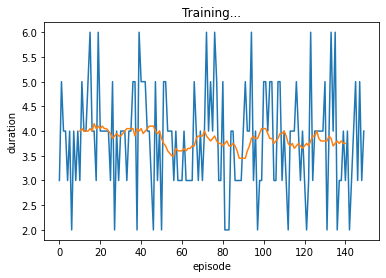

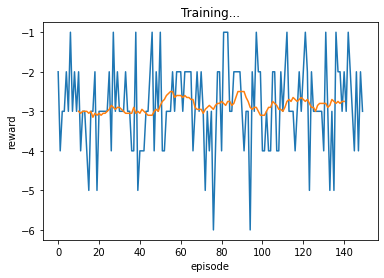

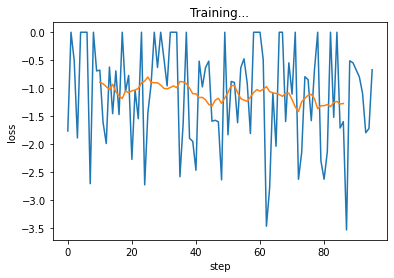

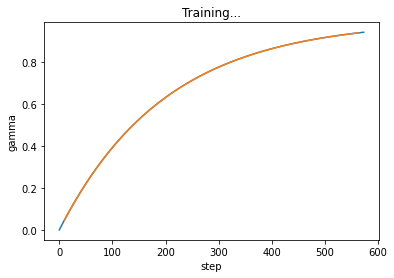

In [52]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=150,
    training=TrainConfig(optimizer='adam', lr=0.01, batch_size=32, train_interval=32, clear_memory=True),
    seed=1
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000]], requires_grad=True), Parameter containing:
tensor([-0.2260, -0.1452], requires_grad=True)]
=========================episode 0 lorry======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 broil-------
reward -1 done False action 0
------guess 2 0 world-------
reward -1 done False action 0
------guess 3 1 lorry-------
reward 0 done True action 1
episode 0 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.014888060396937353  steps 4  memory 0
=========================episode 1 rebar======================
------guess 0 0 later-------
reward -1 done False action 0
------guess 1 0 shear-------
reward -1 done False action 0
------guess 2 0 cedar-------
reward -1 done False action 0
------guess 3 0 rebar-------
reward 0 

------guess 0 1 reset-------
reward -1 done False action 1
------guess 1 0 salon-------
reward -1 done False action 0
------guess 2 1 sonic-------
reward -1 done False action 1
------guess 3 0 snowy-------
reward 0 done True action 0
episode 21 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.32631996075113234  steps 80  memory 76
=========================episode 22 motif======================
------guess 0 0 later-------
reward -1 done False action 0
------guess 1 1 pithy-------
reward -1 done False action 1
------guess 2 1 motif-------
reward 0 done True action 1
episode 22 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.3363497498636806  steps 83  memory 80
=========================episode 23 crowd======================
------guess 0 0 alert-------
reward -1 done False action 0
------guess 1 1 occur-------
reward -1 done False action 1
------guess 2 0 crony-------
reward -1 done False action 0
------guess 3 0 cross-------
reward -1 done False action 0
------guess 4 0 crowd---

------guess 1 1 dozen-------
reward -1 done False action 1
------guess 2 0 dealt-------
reward -1 done False action 0
------guess 3 0 devil-------
reward 0 done True action 0
episode 43 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5461552047176441  steps 159  memory 59
=========================episode 44 ditto======================
------guess 0 0 alert-------
reward -1 done False action 0
------guess 1 0 stoic-------
reward -1 done False action 0
------guess 2 0 pinto-------
reward -1 done False action 0
------guess 3 1 ditto-------
reward 0 done True action 1
episode 44 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5551419337770589  steps 163  memory 63
=========================episode 45 abase======================
------guess 0 1 ombre-------
reward -1 done False action 1
------guess 1 0 baste-------
reward -1 done False action 0
------guess 2 1 abuse-------
reward -1 done False action 1
------guess 3 0 abase-------
reward 0 done True action 0
episode 45 finished.  rew

------guess 2 1 bluer-------
reward -1 done False action 1
------guess 3 0 older-------
reward -1 done False action 0
------guess 4 0 flyer-------
reward 0 done True action 0
episode 64 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.6988057880877978  steps 241  memory 12
=========================episode 65 rehab======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 raise-------
reward -1 done False action 0
------guess 2 0 reach-------
reward -1 done False action 0
------guess 3 1 rehab-------
reward 0 done True action 1
episode 65 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.7047698330759857  steps 245  memory 17
=========================episode 66 brink======================
------guess 0 1 wispy-------
reward -1 done False action 1
------guess 1 1 ratio-------
reward -1 done False action 1
------guess 2 0 idler-------
reward -1 done False action 0
------guess 3 0 bring-------
reward -1 done False action 0
------guess 4 0 brink--

------guess 3 0 rumor-------
reward 0 done True action 0
episode 86 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8060199577091081  steps 329  memory 5
=========================episode 87 wince======================
------guess 0 1 bleat-------
reward -1 done False action 1
------guess 1 0 snore-------
reward -1 done False action 0
------guess 2 0 niche-------
reward -1 done False action 0
------guess 3 0 mince-------
reward -1 done False action 0
------guess 4 0 wince-------
reward 0 done True action 0
episode 87 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.810809342018018  steps 334  memory 9
=========================episode 88 haste======================
------guess 0 1 pecan-------
reward -1 done False action 1
------guess 1 0 alert-------
reward -1 done False action 0
------guess 2 0 saute-------
reward -1 done False action 0
------guess 3 0 haste-------
reward 0 done True action 0
episode 88 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8145555680440291  steps 

------guess 1 0 roast-------
reward -1 done False action 0
------guess 2 0 grant-------
reward -1 done False action 0
------guess 3 0 craft-------
reward -1 done False action 0
------guess 4 0 tract-------
reward 0 done True action 0
episode 108 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.8712650964121957  steps 411  memory 86
=========================episode 109 stove======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 stone-------
reward -1 done False action 0
------guess 2 0 stoke-------
reward -1 done False action 0
------guess 3 0 stove-------
reward 0 done True action 0
episode 109 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8738142182949612  steps 415  memory 91
=========================episode 110 press======================
------guess 0 0 later-------
reward -1 done False action 0
------guess 1 0 snore-------
reward -1 done False action 0
------guess 2 0 rebus-------
reward -1 done False action 0
------guess 3 0 cre

------guess 0 1 shown-------
reward -1 done False action 1
------guess 1 0 adore-------
reward -1 done False action 0
------guess 2 0 abort-------
reward -1 done False action 0
------guess 3 0 agora-------
reward 0 done True action 0
episode 129 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9141368045588332  steps 492  memory 40
=========================episode 130 essay======================
------guess 0 0 later-------
reward -1 done False action 0
------guess 1 0 ocean-------
reward -1 done False action 0
------guess 2 0 essay-------
reward 0 done True action 0
episode 130 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9154151409984354  steps 495  memory 44
=========================episode 131 slate======================
------guess 0 1 rehab-------
reward -1 done False action 1
------guess 1 0 slate-------
reward 0 done True action 0
episode 131 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9162567744078041  steps 497  memory 47
=========================episode 132

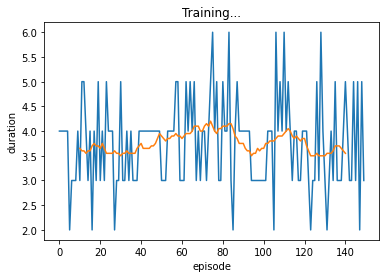

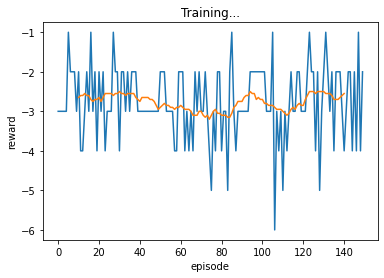

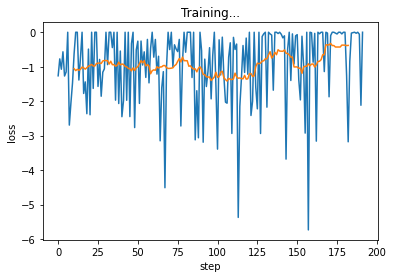

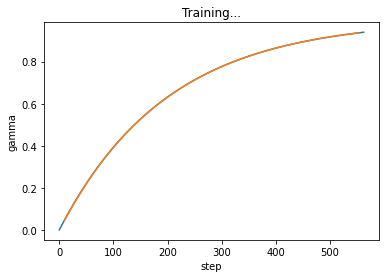

In [59]:
plot_all(*run_experiment(
    model=ModelConfig(name='linear'),
    num_episodes=150,
    training=TrainConfig(optimizer='adam', lr=0.03, batch_size=32, train_interval=32, clear_memory=True)
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 1 1 drank-------
reward -1 done False action 1
------guess 2 1 drake-------
reward 0 done True action 1
episode 14 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.23279405002414433  steps 54  memory 51
=========================episode 15 aging======================
------guess 0 1 natal-------
reward -1 done False action 1
------guess 1 0 snare-------
reward -1 done False action 0
------guess 2 1 woman-------
reward -1 done False action 1
------guess 3 1 aping-------
reward -1 done False action 1
------guess 4 0 aging-------
reward 0 done True action 0
episode 15 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.25173643242143473  steps 59  memory 54
=========================episode 16 sprig======================
------guess 0 0 later-------
reward -1 done False action 0
------guess 1 1 frock-------
reward -1 done False action 1
------guess 2 0 spurn-------
reward -1 done False action 0
------guess 3 0 sprig-------
reward 0 done True action 0
episode 16 finished.  rew

------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 slant-------
reward -1 done False action 0
------guess 2 0 plant-------
reward 0 done True action 0
episode 38 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.5083558025390349  steps 143  memory 44
=========================episode 39 bleed======================
------guess 0 1 lucky-------
reward -1 done False action 1
------guess 1 1 float-------
reward -1 done False action 1
------guess 2 1 bless-------
reward -1 done False action 1
------guess 3 0 blend-------
reward -1 done False action 0
------guess 4 1 bleed-------
reward 0 done True action 1
episode 39 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.5204945410251058  steps 148  memory 47
=========================episode 40 easel======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 laden-------
reward -1 done False action 0
------guess 2 0 camel-------
reward -1 done False action 0
------guess 3 0 easel--

------guess 0 1 dowdy-------
reward -1 done False action 1
------guess 1 0 later-------
reward -1 done False action 0
------guess 2 0 irate-------
reward 0 done True action 0
episode 60 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.6753475326416503  steps 226  memory 127
=========================episode 61 train======================
------guess 0 0 alert-------
reward -1 done False action 0
------guess 1 0 ratio-------
reward -1 done False action 0
------guess 2 1 train-------
reward 0 done True action 1
episode 61 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.680180978183696  steps 229  memory 130
=========================episode 62 tribe======================
------guess 0 0 later-------
reward -1 done False action 0
------guess 1 0 store-------
reward -1 done False action 0
------guess 2 0 trice-------
reward -1 done False action 0
------guess 3 0 tripe-------
reward -1 done False action 0
------guess 4 0 tribe-------
reward 0 done True action 0
episode 62 finished.  re

------guess 1 0 stoic-------
reward -1 done False action 0
------guess 2 0 dusty-------
reward -1 done False action 0
------guess 3 0 musty-------
reward 0 done True action 0
episode 82 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.785618898573022  steps 309  memory 49
=========================episode 83 prime======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 snore-------
reward -1 done False action 0
------guess 2 0 price-------
reward -1 done False action 0
------guess 3 0 pride-------
reward -1 done False action 0
------guess 4 0 prime-------
reward 0 done True action 0
episode 83 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.790911986826717  steps 314  memory 53
=========================episode 84 junta======================
------guess 0 0 alert-------
reward -1 done False action 0
------guess 1 0 satin-------
reward -1 done False action 0
------guess 2 0 tonga-------
reward -1 done False action 0
------guess 3 0 junta----

------guess 1 0 raise-------
reward -1 done False action 0
------guess 2 0 crane-------
reward -1 done False action 0
------guess 3 0 drape-------
reward 0 done True action 0
episode 104 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8577259284134864  steps 391  memory 131
=========================episode 105 wreck======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 snore-------
reward -1 done False action 0
------guess 2 0 perch-------
reward -1 done False action 0
------guess 3 0 wreck-------
reward 0 done True action 0
episode 105 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8605431437849491  steps 395  memory 135
=========================episode 106 torso======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 snort-------
reward -1 done False action 0
------guess 2 0 torus-------
reward -1 done False action 0
------guess 3 0 torso-------
reward 0 done True action 0
episode 106 finishe

------guess 2 0 sepia-------
reward -1 done False action 0
------guess 3 0 heady-------
reward -1 done False action 0
------guess 4 0 heavy-------
reward 0 done True action 0
episode 125 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9069855107893365  steps 476  memory 215
=========================episode 126 daunt======================
------guess 0 0 alert-------
reward -1 done False action 0
------guess 1 0 saint-------
reward -1 done False action 0
------guess 2 0 daunt-------
reward 0 done True action 0
episode 126 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9083703161224952  steps 479  memory 220
=========================episode 127 wrack======================
------guess 0 0 alert-------
reward -1 done False action 0
------guess 1 0 sonar-------
reward -1 done False action 0
------guess 2 0 rapid-------
reward -1 done False action 0
------guess 3 0 crazy-------
reward -1 done False action 0
------guess 4 0 wrack-------
reward 0 done True action 0
episode 127 finishe

------guess 3 0 sheen-------
reward -1 done False action 0
------guess 4 0 semen-------
reward 0 done True action 0
episode 147 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9394932288274196  steps 562  memory 301
=========================episode 148 gully======================
------guess 0 0 alert-------
reward -1 done False action 0
------guess 1 0 solid-------
reward -1 done False action 0
------guess 2 0 mulch-------
reward -1 done False action 0
------guess 3 0 bulky-------
reward -1 done False action 0
------guess 4 0 pulpy-------
reward -1 done False action 0
------guess 5 0 gully-------
reward 0 done True action 0
episode 148 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.9412814741661277  steps 568  memory 306
=========================episode 149 woken======================
------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 nosey-------
reward -1 done False action 0
------guess 2 0 coven-------
reward -1 done False action 0
------guess 3 0 w

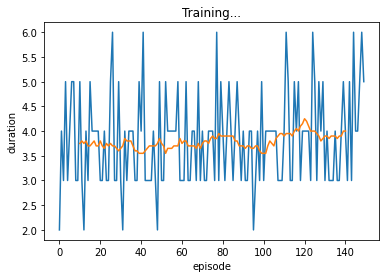

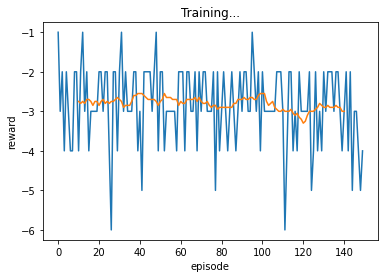

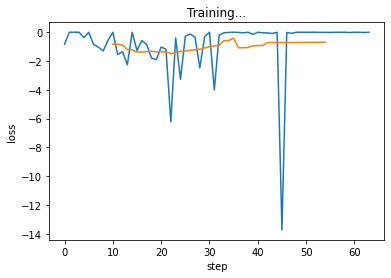

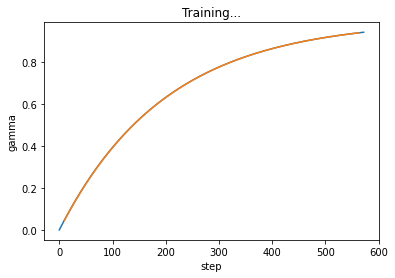

In [60]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=150,
    training=TrainConfig(optimizer='adam', lr=0.03, batch_size=32, train_interval=32, clear_memory=True)
    ))

pn params [Parameter containing:
tensor([[-0.0025,  0.1788, -0.2743, -0.2453, -0.1284,  0.0894, -0.0066,  0.2643,
         -0.0296],
        [ 0.0882, -0.1007, -0.0655, -0.3184, -0.2208, -0.1374,  0.0123,  0.1318,
          0.2000],
        [-0.2260, -0.1452,  0.1211,  0.2768, -0.0686,  0.2494, -0.0537,  0.0353,
          0.3018],
        [-0.3092, -0.2098, -0.0844, -0.1299,  0.2880, -0.2161, -0.1534, -0.2329,
         -0.3122],
        [-0.1946,  0.2865,  0.1487,  0.1616,  0.0175, -0.1709,  0.0564, -0.3112,
         -0.2409],
        [-0.1718,  0.2103,  0.1954, -0.1478, -0.0120,  0.2132,  0.3314,  0.1323,
          0.0450],
        [ 0.2235, -0.1963,  0.0621, -0.2584, -0.2310, -0.1722,  0.1508,  0.1341,
         -0.1975],
        [ 0.1007,  0.1830, -0.0421,  0.0127,  0.0772,  0.2068,  0.3201, -0.2569,
         -0.1222],
        [ 0.1310,  0.2762,  0.2901,  0.2941,  0.0663, -0.2899,  0.0307, -0.2085,
         -0.3107],
        [ 0.2962,  0.2535, -0.3325,  0.0624, -0.0562, -0.0549, -0.1

------guess 2 1 drake-------
reward 0 done True action 1
episode 14 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.23279405002414433  steps 54  memory 51
=========================episode 15 aging======================
------guess 0 1 natal-------
reward -1 done False action 1
------guess 1 0 snare-------
reward -1 done False action 0
------guess 2 1 woman-------
reward -1 done False action 1
------guess 3 1 aping-------
reward -1 done False action 1
------guess 4 0 aging-------
reward 0 done True action 0
episode 15 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.25173643242143473  steps 59  memory 54
=========================episode 16 sprig======================
------guess 0 0 later-------
reward -1 done False action 0
------guess 1 1 frock-------
reward -1 done False action 1
------guess 2 0 spurn-------
reward -1 done False action 0
------guess 3 0 sprig-------
reward 0 done True action 0
episode 16 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.26655304377571076  st

------guess 0 0 alter-------
reward -1 done False action 0
------guess 1 0 raise-------
reward -1 done False action 0
------guess 2 0 opera-------
reward -1 done False action 0
------guess 3 0 cream-------
reward 0 done True action 0
episode 37 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.5034146962085905  steps 141  memory 137
=========================episode 38 bulky======================
------guess 0 1 aunty-------
reward -1 done False action 1
------guess 1 1 bushy-------
reward -1 done False action 1
------guess 2 1 buddy-------
reward -1 done False action 1
------guess 3 1 buggy-------
reward -1 done False action 1
------guess 4 1 burly-------
reward -1 done False action 1
------guess 5 1 bulky-------
reward 0 done True action 1
episode 38 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.5180910099097975  steps 147  memory 141
=========================episode 39 sully======================
------guess 0 1 graze-------
reward -1 done False action 1
------guess 1 1 cluck

------guess 0 1 pupal-------
reward -1 done False action 1
------guess 1 1 dusty-------
reward -1 done False action 1
------guess 2 1 munch-------
reward -1 done False action 1
------guess 3 1 queen-------
reward 0 done True action 1
episode 58 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.680180978183696  steps 229  memory 33
=========================episode 59 lunar======================
------guess 0 1 reset-------
reward -1 done False action 1
------guess 1 1 prowl-------
reward -1 done False action 1
------guess 2 1 flair-------
reward -1 done False action 1
------guess 3 1 lunar-------
reward 0 done True action 1
episode 59 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.6865138191173947  steps 233  memory 37
=========================episode 60 dingo======================
------guess 0 1 twice-------
reward -1 done False action 1
------guess 1 1 girly-------
reward -1 done False action 1
------guess 2 1 bingo-------
reward -1 done False action 1
------guess 3 1 dingo---

------guess 3 1 weary-------
reward 0 done True action 1
episode 79 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.785618898573022  steps 309  memory 113
=========================episode 80 fauna======================
------guess 0 1 slave-------
reward -1 done False action 1
------guess 1 1 rabbi-------
reward -1 done False action 1
------guess 2 1 wagon-------
reward -1 done False action 1
------guess 3 1 candy-------
reward -1 done False action 1
------guess 4 1 fauna-------
reward 0 done True action 1
episode 80 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.790911986826717  steps 314  memory 117
=========================episode 81 there======================
------guess 0 1 boxer-------
reward -1 done False action 1
------guess 1 1 wrest-------
reward -1 done False action 1
------guess 2 1 there-------
reward 0 done True action 1
episode 81 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.7940249017951165  steps 317  memory 122
=========================episode 82 befi

------guess 2 1 giant-------
reward -1 done False action 1
------guess 3 1 tiara-------
reward 0 done True action 1
episode 99 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.8598441133841846  steps 394  memory 198
=========================episode 100 snore======================
------guess 0 1 cagey-------
reward -1 done False action 1
------guess 1 1 error-------
reward -1 done False action 1
------guess 2 1 worse-------
reward -1 done False action 1
------guess 3 1 spore-------
reward -1 done False action 1
------guess 4 1 shore-------
reward -1 done False action 1
------guess 5 1 snore-------
reward 0 done True action 1
episode 100 finished.  reward -5  eps [0.9, 0.05, 200]  gamma 0.8639863458331508  steps 400  memory 202
=========================episode 101 stave======================
------guess 0 1 shirk-------
reward -1 done False action 1
------guess 1 1 smelt-------
reward -1 done False action 1
------guess 2 1 stone-------
reward -1 done False action 1
------guess 3 1 st

------guess 2 1 eight-------
reward 0 done True action 1
episode 119 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9069855107893365  steps 476  memory 281
=========================episode 120 tribe======================
------guess 0 1 agent-------
reward -1 done False action 1
------guess 1 1 berth-------
reward -1 done False action 1
------guess 2 1 tuber-------
reward -1 done False action 1
------guess 3 1 tribe-------
reward 0 done True action 1
episode 120 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9088273210774022  steps 480  memory 284
=========================episode 121 decor======================
------guess 0 1 spasm-------
reward -1 done False action 1
------guess 1 1 known-------
reward -1 done False action 1
------guess 2 1 torch-------
reward -1 done False action 1
------guess 3 1 decor-------
reward 0 done True action 1
episode 121 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9106326610782468  steps 484  memory 288
=========================episode 

------guess 2 1 horse-------
reward -1 done False action 1
------guess 3 1 curse-------
reward -1 done False action 1
------guess 4 1 nurse-------
reward 0 done True action 1
episode 139 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9394932288274196  steps 562  memory 365
=========================episode 140 broad======================
------guess 0 1 cloak-------
reward -1 done False action 1
------guess 1 1 broad-------
reward 0 done True action 1
episode 140 finished.  reward -1  eps [0.9, 0.05, 200]  gamma 0.9400952812598878  steps 564  memory 370
=========================episode 141 floss======================
------guess 0 1 spank-------
reward -1 done False action 1
------guess 1 1 first-------
reward -1 done False action 1
------guess 2 1 flesh-------
reward -1 done False action 1
------guess 3 1 floss-------
reward 0 done True action 1
episode 141 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9412814741661277  steps 568  memory 372
=========================episode 

------guess 2 1 humph-------
reward -1 done False action 1
------guess 3 1 jumpy-------
reward -1 done False action 1
------guess 4 1 dumpy-------
reward 0 done True action 1
episode 160 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.959844666176376  steps 644  memory 63
=========================episode 161 satin======================
------guess 0 1 buggy-------
reward -1 done False action 1
------guess 1 1 defer-------
reward -1 done False action 1
------guess 2 1 slack-------
reward -1 done False action 1
------guess 3 1 saint-------
reward -1 done False action 1
------guess 4 1 satin-------
reward 0 done True action 1
episode 161 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9608361049010129  steps 649  memory 68
=========================episode 162 ovine======================
------guess 0 1 stiff-------
reward -1 done False action 1
------guess 1 1 plier-------
reward -1 done False action 1
------guess 2 1 deign-------
reward -1 done False action 1
------guess 3 1 ovin

------guess 2 1 octet-------
reward 0 done True action 1
episode 181 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9732173235073618  steps 725  memory 146
=========================episode 182 straw======================
------guess 0 1 alley-------
reward -1 done False action 1
------guess 1 1 chair-------
reward -1 done False action 1
------guess 2 1 borax-------
reward -1 done False action 1
------guess 3 1 strap-------
reward -1 done False action 1
------guess 4 1 straw-------
reward 0 done True action 1
episode 182 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9738785901460818  steps 730  memory 149
=========================episode 183 crook======================
------guess 0 1 arrow-------
reward -1 done False action 1
------guess 1 1 groom-------
reward -1 done False action 1
------guess 2 1 brood-------
reward -1 done False action 1
------guess 3 1 troop-------
reward -1 done False action 1
------guess 4 1 crook-------
reward 0 done True action 1
episode 183 finishe

------guess 1 1 burst-------
reward -1 done False action 1
------guess 2 1 circa-------
reward -1 done False action 1
------guess 3 1 larva-------
reward 0 done True action 1
episode 202 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9824025275843766  steps 809  memory 229
=========================episode 203 shank======================
------guess 0 1 deity-------
reward -1 done False action 1
------guess 1 1 champ-------
reward -1 done False action 1
------guess 2 1 shank-------
reward 0 done True action 1
episode 203 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.9826645198165338  steps 812  memory 233
=========================episode 204 proxy======================
------guess 0 1 bathe-------
reward -1 done False action 1
------guess 1 1 woody-------
reward -1 done False action 1
------guess 2 1 crony-------
reward -1 done False action 1
------guess 3 1 proxy-------
reward 0 done True action 1
episode 204 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.98300778532303

------guess 2 1 bezel-------
reward -1 done False action 1
------guess 3 1 bulky-------
reward 0 done True action 1
episode 223 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9884376367125315  steps 893  memory 313
=========================episode 224 frond======================
------guess 0 1 cream-------
reward -1 done False action 1
------guess 1 1 brink-------
reward -1 done False action 1
------guess 2 1 prong-------
reward -1 done False action 1
------guess 3 1 frond-------
reward 0 done True action 1
episode 224 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9886665868453326  steps 897  memory 317
=========================episode 225 truth======================
------guess 0 1 wimpy-------
reward -1 done False action 1
------guess 1 1 bluff-------
reward -1 done False action 1
------guess 2 1 stung-------
reward -1 done False action 1
------guess 3 1 truth-------
reward 0 done True action 1
episode 225 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.98889100346175

------guess 1 1 heath-------
reward -1 done False action 1
------guess 2 1 verse-------
reward -1 done False action 1
------guess 3 1 fever-------
reward 0 done True action 1
episode 243 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9924029859724224  steps 977  memory 397
=========================episode 244 basin======================
------guess 0 1 angel-------
reward -1 done False action 1
------guess 1 1 piano-------
reward -1 done False action 1
------guess 2 1 cairn-------
reward -1 done False action 1
------guess 3 1 satin-------
reward -1 done False action 1
------guess 4 1 basin-------
reward 0 done True action 1
episode 244 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9925905569170853  steps 982  memory 401
=========================episode 245 click======================
------guess 0 1 handy-------
reward -1 done False action 1
------guess 1 1 brute-------
reward -1 done False action 1
------guess 2 1 flock-------
reward -1 done False action 1
------guess 3 1 c

------guess 1 1 khaki-------
reward -1 done False action 1
------guess 2 1 delve-------
reward -1 done False action 1
------guess 3 1 detox-------
reward 0 done True action 1
episode 263 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9950580732823202  steps 1063  memory 483
=========================episode 264 udder======================
------guess 0 1 beret-------
reward -1 done False action 1
------guess 1 1 wooer-------
reward -1 done False action 1
------guess 2 1 drier-------
reward -1 done False action 1
------guess 3 1 under-------
reward -1 done False action 1
------guess 4 1 udder-------
reward 0 done True action 1
episode 264 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9951800898877292  steps 1068  memory 487
=========================episode 265 where======================
------guess 0 1 leery-------
reward -1 done False action 1
------guess 1 1 exert-------
reward -1 done False action 1
------guess 2 1 where-------
reward 0 done True action 1
episode 265 finis

------guess 3 1 tramp-------
reward -1 done False action 1
------guess 4 1 trawl-------
reward 0 done True action 1
episode 283 finished.  reward -4  eps [0.9, 0.05, 200]  gamma 0.9967202890976564  steps 1145  memory 564
=========================episode 284 visor======================
------guess 0 1 salve-------
reward -1 done False action 1
------guess 1 1 virus-------
reward -1 done False action 1
------guess 2 1 visor-------
reward 0 done True action 1
episode 284 finished.  reward -2  eps [0.9, 0.05, 200]  gamma 0.996769117631655  steps 1148  memory 569
=========================episode 285 lapse======================
------guess 0 1 enemy-------
reward -1 done False action 1
------guess 1 1 arose-------
reward -1 done False action 1
------guess 2 1 false-------
reward -1 done False action 1
------guess 3 1 lapse-------
reward 0 done True action 1
episode 285 finished.  reward -3  eps [0.9, 0.05, 200]  gamma 0.9968330933889381  steps 1152  memory 572
=========================episod

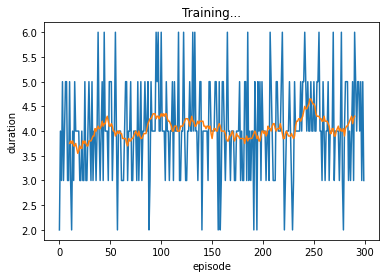

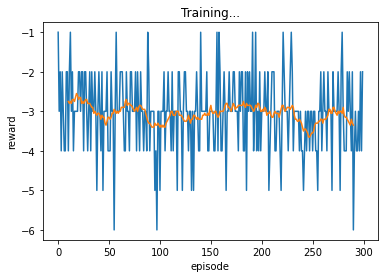

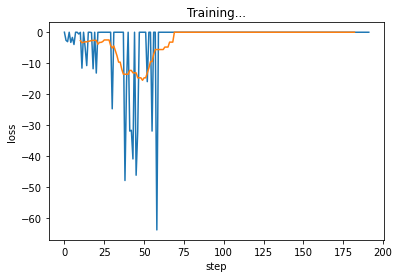

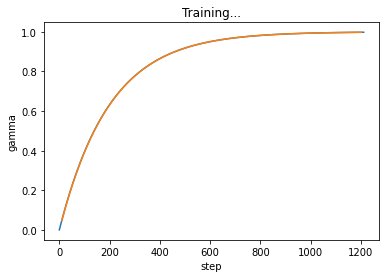

In [63]:
plot_all(*run_experiment(
    model=ModelConfig(name='nn'),
    num_episodes=300,
    training=TrainConfig(optimizer='adam', lr=0.03, batch_size=64, train_interval=64, clear_memory=True)
    ))